# CS171-EE142 - Fall 2022 - Homework 3

# Due: Tuesday, November 15, 2022 @ 11:59pm

### Maximum points: 80 pts


## Submit your solution to Gradescope:
1. Submit a single PDF to **HW3**
2. Submit your jupyter notebook to **HW3-code**

**See the additional submission instructions at the end of this notebook**


## Enter your information below:

### Your Name (submitter): Ivan Neto

### Your student ID (submitter): 862228249
    
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>


## Academic Integrity
Each assignment should be done  individually. You may discuss general approaches with other students in the class, and ask questions to the TAs, but  you must only submit work that is yours . If you receive help by any external sources (other than the TA and the instructor), you must properly credit those sources, and if the help is significant, the appropriate grade reduction will be applied. If you fail to do so, the instructor and the TAs are obligated to take the appropriate actions outlined at http://conduct.ucr.edu/policies/academicintegrity.html . Please read carefully the UCR academic integrity policies included in the link.


# Overview 
In this assignment you will implement a two-layer neural network. You will implement the loss functions, gradients, optimizers to train the network and test its performance on MNIST dataset. 

For this assignment we will use the functionality of Pandas (https://pandas.pydata.org/), Matplotlib (https://matplotlib.org/), and Numpy (http://www.numpy.org/). 

If you are asked to **implement** a particular functionality, you should **not** use an existing implementation from the libraries above (or some other library that you may find). When in doubt, please ask. 

Before you start, make sure you have installed all those packages in your local Jupyter instance

## Read *all* cells carefully and answer all parts (both text and missing code)

You will complete all the code marked `TODO` and answer descriptive/derivation questions 



In [351]:
import numpy as np
import matplotlib.pyplot as plt

# make sure you import here everything else you may need

### Load MNIST Dataset 

For this assignment, we will use [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digits data set. The dataset consists 10 handwritten digits (0,1,...,9). It is a widely used dataset to demonstrate simple image classification problem.

MNIST dataset is publicly available from different sources. We will be using MNIST from Keras package. If you do not have Keras installed, you can find the installation guide [here](https://www.tutorialspoint.com/keras/keras_installation.htm). 

In short, you need to run ```conda install -c anaconda keras``` or ```pip install keras```

The training data consists of 60000 images of size $28 \times 28$ pixels; the test data consists of 10000 images.

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


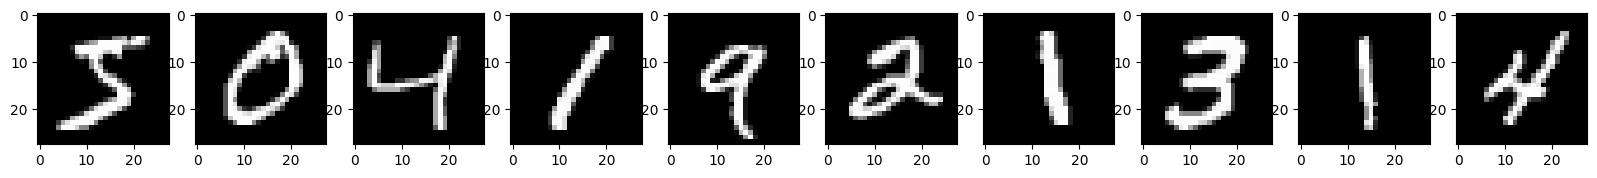

In [352]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training data shape:',x_train.shape)
print('Test data shape:',x_test.shape)

n_img=10
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
    plt.subplot(1,n_img,i+1)
    plt.imshow(x_train[i])
plt.show()

We will be vectorizing the training and test images. So, the size of each vector will be 784.

In [353]:
x_train=x_train.reshape(x_train.shape[0],-1)
x_test=x_test.reshape(x_test.shape[0],-1)

print('Training data shape after reshaping:',x_train.shape)
print('Test data shape after reshaping::',x_test.shape)

Training data shape after reshaping: (60000, 784)
Test data shape after reshaping:: (10000, 784)


## Question 1: Binary classification using neural network [45 pts]

We will start with classification of images for two different digits using a two-layer network with a cross entropy loss. 

In the next question, we will extend the same architecture to multi-class classification. 

Pick any two digits out of ten for our classification (say 5 and 8), which we will assign label "0" or "1". 

Pick same number of images from each class for training and create arrays for input and output (say 1000). 

```
# train_x -- N x 784 array of training input
# train_y -- N x 1 array of binary labels 
```  

If you use 1000 images from each class N = 2000. You can increase the number of training samples if you like. It is just a suggestion. 


We also need to transpose the dimension of the data so that their size becomes $784\times N$. It will be helpful to feed it to our model based on our notations.


In [354]:
def extract_binary_classification_dataset(x, y, label1, label2, num_samples):
    """Make a subset dataset from MNIST, containing only 2 classes for binary classification task 
    Args:
        x (numpy.ndarray): data, can be x_train or x_test
        y (numpy.ndarray): labels of data, can be y_train or y_test
        label1 (int): the first class you pick, e.g. 5
        label2 (int): the second class you pick, e.g. 8
        num_samples (int): the number of images you select for each class, e.g. 1000
    Returns:
        x_ (numpy.ndarray): the data for 2 picked classes
        y_ (numpy.ndarray): the corresponding labels for 2 picked classes
    """
    # for class 1
    x1 = x[y == label1]
    x1 = x1[:num_samples]
    y1 = np.zeros(len(x1))

    # for class 2
    x2 = x[y == label2]
    x2 = x2[:num_samples]
    y2 = np.ones(len(x2))

    # combine 2 classes
    x_ = np.concatenate((x1,x2),axis=0)
    y_ = np.concatenate((y1,y2),axis=0)
    return x_, y_


# Pick your own digits
label1 = 5
label2 = 8
num_samples = 1000

# Train & test data
train_x, train_y = extract_binary_classification_dataset(x_train, y_train, label1, label2, num_samples)
test_x, test_y = extract_binary_classification_dataset(x_test, y_test, label1, label2, num_samples)

# reshape data 
train_x = train_x.T
test_x = test_x.T
print("Training data shape:", train_x.shape)
print("Test data shape:", test_x.shape)

Training data shape: (784, 2000)
Test data shape: (784, 1866)


### Network Architecture

We will be using a two layer neural network in our experiment. The input layer will have 784 nodes, the hidden layer will have 256 nodes and the output layer will have 1 node. Each node will have $\textit{sigmoid}$ activation function.

The equations for feedforward operation will be the following:

$$\mathbf{z}^{(1)}=W^{(1)} \mathbf{x}+ \mathbf{b}^{(1)}\\\mathbf{y}^{(1)}=\varphi(\mathbf{z}^{(1)})\\\mathbf{z}^{(2)}=W^{(2)}  \mathbf{y}^{(1)}+ \mathbf{b}^{(2)} \\\mathbf{y}^{(2)}=\varphi(\mathbf{z}^{(2)})$$

where $\mathbf{x}\in \mathbb{R}^{784}$ is the input layer, $\mathbf{y}^{(1)}\in \mathbb{R}^{256}$ is the hidden layer, $\mathbf{y}^{(2)} \in \mathbb{R}$ is the output layer, $W^{(1)}\in \mathbb{R}^{256\times 784}$ is the first layer weights, $W^{(2)}\in \mathbb{R}^{1\times 256}$ is the second layer weights, $\mathbf{b}^{(1)}\in \mathbb{R}^{256}$ is the first layer bias, $\mathbf{b}^{(2)}\in \mathbb{R}$ is the second layer bias, $\varphi(\cdot)$ is the activation function.

### Network initialization [5 pts]

We initialize the weights for $W^{(1)}$ and $W^{(2)}$ with random values drawn from normal distribution with zero mean and 0.01 standard deviation. We will initialize bias vectors $\mathbf{b}^{(1)}$ and $\mathbf{b^{(2)}}$ with zero values. 

We can fix the seed for random initialization for reproducibility.

In [355]:
def TwoLayerNetwork(layer_dims=[784,256,1]):
    # Fix the seed
    np.random.seed(3)

    # TODO
    # grab [784, 256]
    w1 = np.random.normal(loc=0, scale=0.01, size=[256, 784])
    # grab [256, 1]
    w2 = np.random.normal(loc=0, scale=0.01, size=[1, 256])
    # init b1
    b1 = np.zeros((layer_dims[1], 1))
    # init b2
    b2 = np.zeros((layer_dims[2], 1))

    return [w1, b1, w2, b2]

### Sigmoid activation function 
Now we will write the sigmoid activation function as 

$$ \varphi(z) = \frac{1}{1+e^{-z}}$$

Note that derivative of __sigmoid__ is $\varphi'(z) = \varphi(z) (1-\varphi(z))$. 

In [356]:
def sigmoid(Z):
    # Input: Z -- numpy.ndarray
    # TODO
    probs = 1 / (1 + np.e**(-Z))
    return probs

### Cross entropy loss function [5 pts]
We will minimize the binary cross entropy loss function. You will use the true labels and predicted labels of a batch of N samples. 

Binary crossentropy loss for $i^{th}$ sample can be written as 

$$Loss_i = -y_i \log y^{(2)}_i- (1-y_i) \log (1-y^{(2)}_i)$$

where $y_i$ is the true label. We can find the average loss for a batch of N samples as $Loss=\frac{1}{N}\sum_{i=1}^{N} Loss_i$.

Note that the gradient of the cross entropy loss w.r.t. the output is 

$$ \nabla_{y^{(2)}} Loss_i = -\frac{y_i}{y_i^{(2)}} + \frac{1-y_i}{1-y_i^{(2)}} = \frac{y_i^{(2)}-y_i}{y_i^{(2)}(1-y_i^{(2)})}.$$

We can also show that $$\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i  = \nabla_{y^{(2)}} Loss_i \odot \varphi'(\mathbf{z})= y_i^{(2)}-y_i,$$ 
where $\odot$ denotes element-wise multiplication of the arrays. 

In [357]:
def CrossEntropyLoss(Y_true, Y2):
    # TODO 
    losses = (-Y_true) * np.log(Y2) - (1 - Y_true) * np.log(1 - Y2)
    return np.average(losses)

### Forward propagation  [5 pts]
Next, we will write the code for the forward pass for two layer network. Each layer consists of an affine function (fully-connected layer) followed by an activation function. You wil also return the intermediate results ($\mathbf{x}, \mathbf{z}^{(1)}, \mathbf{y}^{(1)}, \mathbf{z}^{(2)}  $) in addition to final output ($\mathbf{y}^{(2)}$). You will need the intermediate outputs for the backpropagation step.

In [358]:
def forward(X, params):
    # TODO 
    
    # X -- 784 x N array 
    # params -- 
      # W1 -- 256 x 784 matrix 
      # b1 -- 256 x 1 vector 
      # W2 -- 1 x 256 matrix 
      # b2 -- 1 x 1 scalar 
    # Y2 -- 1 x N output 
    
    # grab all parameters
    W1 = params[0]
    B1 = params[1]
    W2 = params[2]
    B2 = params[3]

    # Compute forward propagation
    Z1 = W1 @ X + B1
    Y1 = sigmoid(Z1)
    Z2 = W2 @ Y1 + B2
    Y2 = sigmoid(Z2)
    
    return Y2, [X, Z1, Y1, Z2]

### Backpropagration step [10 pts]
Now we will implement the backpropagation step for the two layer neural network. 

You will need the gradient of the Loss w.r.t. $W^{(l)},\mathbf{b}^{(l)}$ for $l = 1,2$ for all the training samples.  



We saw that we can write the gradient of Loss with respect to $W^{(l)}, \mathbf{b}^{(l)}$ for a single sample as

$$\nabla_{W^{(l)}} Loss_i = \delta^{(l)} \mathbf{y}^{(l-1)T},$$  
$$\nabla_{\mathbf{b}^{(l)}} Loss_i = \delta^{(l)},$$

where 
$$\delta^{(l)} = \nabla_{\mathbf{z}^{(l)}} Loss_i = \nabla_{\mathbf{y}^{(l)}} Loss_i \odot \varphi'(\mathbf{z}^{(l)}).$$ 


For the the last layer, we can compute $\delta^{(L)}$ by plugging the value of $\nabla_{\mathbf{y}^{(L)}} Loss$ as described above. 

For the intermediate layers $l<L$, we can write 
$$\delta^{(l)} = W^{(l+1)T}\delta^{(l+1)} \odot \varphi'(\mathbf{z}^{(l)}).$$ 



**Once we have the gradients $\nabla_{W^{(l)}} Loss_i, \nabla_{\mathbf{b}^{(l)}} Loss_i$ for all $i$. We can compute their average to compute the gradient of the total loss function $\frac{1}{N} \sum_{i=1}^N Loss_i$ as**

$$\nabla_{W^{(l)}} Loss = \frac{1}{N} \sum_i \nabla_{W^{(l)}} Loss_i, $$
$$ \nabla_{\mathbf{b}^{(l)}} Loss = \frac{1}{N} \sum_i  \nabla_{\mathbf{b}^{(l)}} Loss_i.$$

**Please refer to the slides and lectures for more details.**

In [359]:
def backward(Y_true, Y2, intermediate, params):
    
    # Inputs: 
      # Y_true -- 1 x N true labels
      # Y2 -- 1 x N output of the last layer
      # intermediate -- X, Z1, Y1, Z2 
      # params -- W1, b1, W2, b2 
    
    # Outputs:
      # grads -- [grad_W1, grad_b1, grad_W2, grad_b2]
    
    X  = intermediate[0]
    Z1 = intermediate[1]
    Y1 = intermediate[2]
    Z2 = intermediate[3]

    W2 = params[2]

    sigmoid_p_Z2 = np.multiply(sigmoid(Z2), (1 - sigmoid(Z2)))
    grad_loss_y2 = (Y2 - Y_true) / (Y2*(1 - Y2))
    d2 = np.multiply(grad_loss_y2, sigmoid_p_Z2)

    sigmoid_p_Z1 = np.multiply(sigmoid(Z1), (1 - sigmoid(Z1)))
    d1 = np.multiply((np.transpose(W2) @ d2), sigmoid_p_Z1)

    grad_w1 = np.dot(d1, np.transpose(X)) / len(Y_true)
    grad_b1 = np.sum(d1, axis=1, keepdims=True) / len(Y_true)
    grad_w2 = np.dot(d2, np.transpose(Y1)) / len(Y_true)
    grad_b2 = np.sum(d2, axis=1, keepdims=True) / len(Y_true)

    return [grad_w1, grad_b1, grad_w2, grad_b2]

### Optimizer [5 pts]
We will use a standard gradient descent-based optimizer to minimize the loss function. You have already implemented gradient descent in HW2. You may have to adjust learning rate that provides you best training/validation performance. In this exercise, we are not using validation data; in practice, you should use it to tune your hyperparameters such as learning rate, network architecture etc.

You can use same learning rate for all weights in this assignment. 

You should update $W^1, \mathbf{b}^1, W^2, \mathbf{b}^2$ as 
$$ W^1 \gets W^1 - \alpha \nabla_{W^1} Loss $$
$$ \mathbf{b}^1 \gets \mathbf{b}^1 - \alpha \nabla_{\mathbf{b}^1} Loss $$ 
$$ W^2 \gets W^2 - \alpha \nabla_{W^2} Loss $$ 
$$ \mathbf{b}^2 \gets \mathbf{b}^2 - \alpha \nabla_{\mathbf{b}^2} Loss $$ 
$\alpha$ is the learning rate. 

In [360]:
def GD(params, grads, learning_rate):
    
    # updated params = old params - learning rate * gradient of Loss computed at old params
    # TODO 
     
    for i in range(0, len(params)):
        params[i] = params[i] - learning_rate * grads[i]   
     
    return params

### Train the Model [5 pts]
We will train the model using the functions we wrote above. 

First, we specify the number of nodes in the layers, number of epochs and learning rate. Then we initialize the network.

In [361]:
layer_dims = [train_x.shape[0],256,1]
epochs = 100
lr = 0.01

params = TwoLayerNetwork(layer_dims)

Then we train the network for the number of epochs specified above. In every epoch, we will do the following:
1. Calculate the forward pass to get estimated labels.
2. Use the estimated labels calculate loss. We will be recording loss for every epoch.
3. Use backpropagation to calculate gradients.
4. Use gradient descent to update the weights and biases.

You should store the loss value after every epoch in an array ```loss_history```  and print the loss value after every few epochs (say 20). 


In [362]:
# TODO 

loss_history = []
for i in range(1, epochs + 1):
    _Y2, _intermediate = forward(train_x, params)
    loss = CrossEntropyLoss(train_y, _Y2)
    if (i % 10 == 0 or i == 1):
        print(f"Epoch: {i: <4} | Loss: {round(loss, 9):.8f}")
    loss_history.append(loss)
    grads = backward(train_y, _Y2, _intermediate, params)
    params = GD(params, grads, lr)

Epoch: 1    | Loss: 0.69134019
Epoch: 10   | Loss: 0.61614324
Epoch: 20   | Loss: 0.53130191
Epoch: 30   | Loss: 0.44487540
Epoch: 40   | Loss: 0.36816196
Epoch: 50   | Loss: 0.30720631
Epoch: 60   | Loss: 0.26108315
Epoch: 70   | Loss: 0.22618011
Epoch: 80   | Loss: 0.19929726
Epoch: 90   | Loss: 0.17817257
Epoch: 100  | Loss: 0.16124393


Now we will plot the recorded loss values vs epochs. We will observe the training loss decreasing with the epochs.

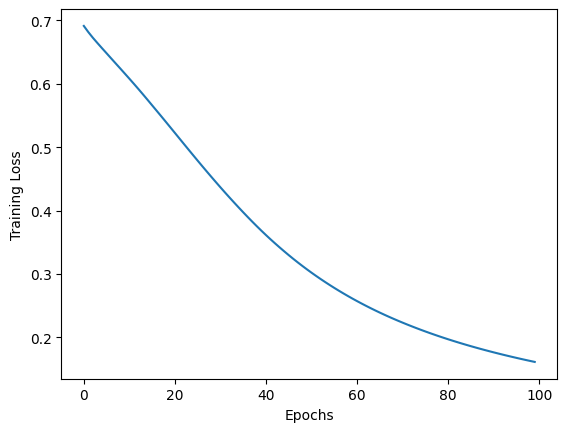

In [363]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

### Evaluation on test data [5 pts]

Now we will be evaluating the accuracy we get from the trained model. We feed training data and test data to the forward model along with the trained parameters. 

Note that, we need to covert the output probability of the forward pass to binary labels before evaluating accuracy. Since the model provides the posterior probability $p(y = 1 | x)$ in range [0,1]. We can binarize them using 0.5 as a theshold (i.e. if $y_i^{(2)}\geq 0.5$, $y_i^{(2)} \gets 1$ otherwise  $y_i^{(2)} \gets 0$).

In [364]:
# TODO
Y2_train, _ = forward(train_x, params)
Y2_train[Y2_train < 0.5] = 0
Y2_train[Y2_train >= 0.5] = 1

print("Training accuracy:", (Y2_train == train_y).sum() / Y2_train.shape[1])

Y2_test, _ = forward(test_x, params)
Y2_test[Y2_test < 0.5] = 0
Y2_test[Y2_test >= 0.5] = 1

print("Test accuracy:", (Y2_test == test_y).sum() / Y2_test.shape[1])

Training accuracy: 0.972
Test accuracy: 0.9469453376205788


### Visualize some of the correct/miscalassified images [5 pts]

Now we will look at some images from training and test sets that were misclassified. 

Training set. 
Pick 5 images from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives

Test set. 
Pick 5 images from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives


Training set examples for true/false positive/negative


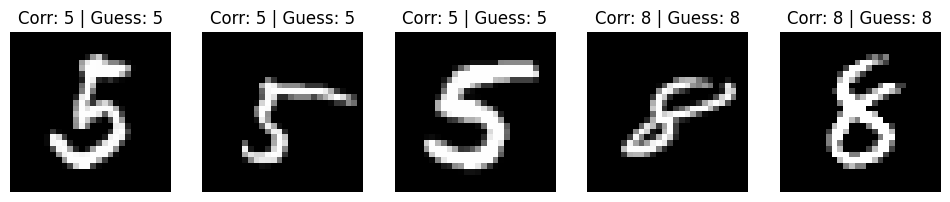

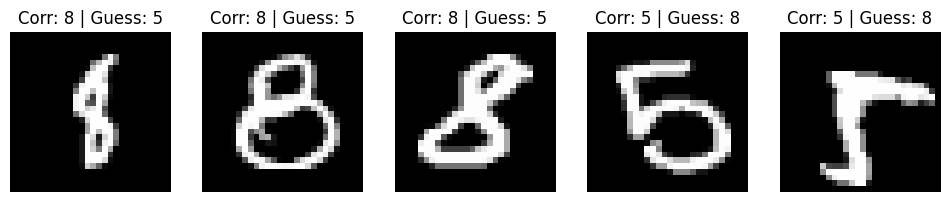

In [365]:
# TODO 
# Training set
print("Training set examples for true/false positive/negative")
Y_hat, caches = forward(train_x, params)

def shuffle_three(a, b, c):
    index = np.random.permutation(len(a))
    return a[index], b[index], c[index]

tr_y = train_y.reshape((1, len(train_y)))

Y_hat, tr_y, tr_x = shuffle_three(Y_hat[0], tr_y[0], train_x.T)

# Create classification vector
Y_hat[Y_hat < 0.5] = 0
Y_hat[Y_hat >= 0.5] = 1

# Create array filters
train_corr = tr_y == Y_hat
train_inco = tr_y != Y_hat

Y_hat_corr = Y_hat[train_corr]

# # perform filtering to plot images
Y_hat_corr = Y_hat[train_corr]
Y_hat_inco = Y_hat[train_inco]
Y_train_corr = tr_y[train_corr]
Y_train_inco = tr_y[train_inco]
correct_images = tr_x[train_corr]
incorrect_images = tr_x[train_inco]

fig = plt.figure(figsize=(12, 12))
# print correctly classified images
for i in range(0, 5):
    ax = fig.add_subplot(1, 5, i + 1)
    img = plt.imshow(correct_images[i].reshape(28, 28))
    corr = 5 if (Y_train_corr[i] == 0) else 8
    guess = 5 if (Y_hat_corr[i] == 0) else 8
    ax.set_title(f"Corr: {corr} | Guess: {guess}")
    ax.axis("off")

fig = plt.figure(figsize=(12, 12))
# print incorrectly classified images
for i in range(0, 5):
    ax = fig.add_subplot(1, 5, i + 1)
    img = plt.imshow(incorrect_images[i].reshape(28, 28))
    corr = 5 if (Y_train_inco[i] == 0) else 8
    guess = 5 if (Y_hat_inco[i] == 0) else 8
    ax.set_title(f"Corr: {corr} | Guess: {guess}")
    ax.axis("off")

test set examples for true/false positive/negative


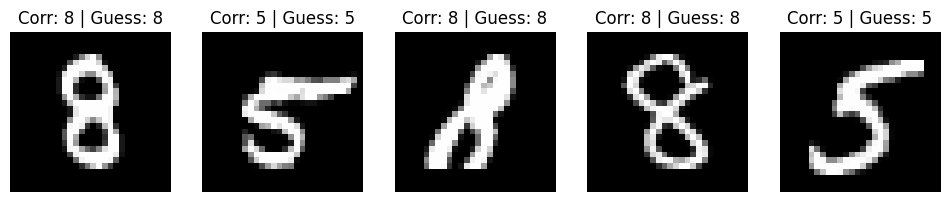

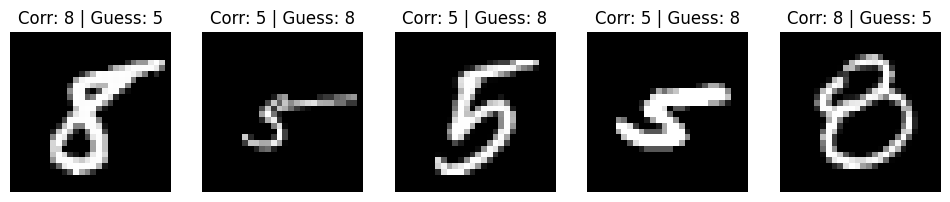

In [366]:
# TODO 
# Training set
print("test set examples for true/false positive/negative")
Y_hat, caches = forward(test_x, params)

def shuffle_three(a, b, c):
    index = np.random.permutation(len(a))
    return a[index], b[index], c[index]

te_y = test_y.reshape((1, len(test_y)))

Y_hat, te_y, te_x = shuffle_three(Y_hat[0], te_y[0], test_x.T)

# Create classification vector
Y_hat[Y_hat < 0.5] = 0
Y_hat[Y_hat >= 0.5] = 1

# Create array filters
train_corr = te_y == Y_hat
train_inco = te_y != Y_hat

Y_hat_corr = Y_hat[train_corr]

# # perform filtering to plot images
Y_hat_corr = Y_hat[train_corr]
Y_hat_inco = Y_hat[train_inco]
Y_test_corr = te_y[train_corr]
Y_test_inco = te_y[train_inco]
correct_images = te_x[train_corr]
incorrect_images = te_x[train_inco]

fig = plt.figure(figsize=(12, 12))
# print correctly classified images
for i in range(0, 5):
    ax = fig.add_subplot(1, 5, i + 1)
    img = plt.imshow(correct_images[i].reshape(28, 28))
    corr = 5 if (Y_test_corr[i] == 0) else 8
    guess = 5 if (Y_hat_corr[i] == 0) else 8
    ax.set_title(f"Corr: {corr} | Guess: {guess}")
    ax.axis("off")

fig = plt.figure(figsize=(12, 12))
# print incorrectly classified images
for i in range(0, 5):
    ax = fig.add_subplot(1, 5, i + 1)
    img = plt.imshow(incorrect_images[i].reshape(28, 28))
    corr = 5 if (Y_test_inco[i] == 0) else 8
    guess = 5 if (Y_hat_inco[i] == 0) else 8
    ax.set_title(f"Corr: {corr} | Guess: {guess}")
    ax.axis("off")



---



## Question 2. Multiclass classification [35 pts] 

Now we will build a classifier to separate all the digits. For this purpose, we will only change the last layer and the loss. 


Instead of using a single output, we will provide 10 outputs; and instead of using a binary cross entropy loss, we will use mutli-class cross entropy loss. 

In multinomal logistic regression (aka softmax regression), we define the posterior probability of label $y \in \{0,\ldots, K-1\}$ as 


$$p(y = c | \mathbf{x}) = \frac{\exp(\mathbf{w}_c^T\mathbf{x})}{\sum_{k=1}^K \exp(\mathbf{w}_k^T\mathbf{x})} = \mathbf{p}_c.$$ 

In other words, last layer of the network provides a probability vector $\mathbf{p} \in \mathbb{R}^K$, such that each $0 \le \mathbf{p}_c \le 1$ and $\sum_c \mathbf{p}_c = 1$. 

### Softmax function [5 pts]

Let us first define the softmax function, which is a multinomal extension of the sigmoid function that maps a vector of length $K$ to a probability vector. 

We can define ```softmax``` function on a vector $\mathbf{z} \in \mathbb{R}^K$ as $\mathbf{p} = \text{softmax}(\mathbf{z})$: 

$$\mathbf{p}_c(\mathbf{z}) = \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)}$$



In [367]:
def softmax(Z):
    # Z -- K x N numpy.ndarray, K is the number of classes, N is the number of samples
    # TODO
    # print(Z[0])
    # print(np.exp(Z))
    # print("================")
    # print(np.sum(np.exp(Z), axis=0))
    # print(Z.T[0])
    # for i in Z.T[0]:
    #     print(i)
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)

We have to note that the numerical range of floating point numbers in numpy is limited. For `float64` the upper bound is $10^{308}$. For exponential, its not difficult to overshoot that limit, in which case python returns `nan`.

To make our softmax function numerically stable, we simply normalize the values in the vector, by multiplying the numerator and denominator with a constant `C` as

\begin{align*}
\mathbf{p}_c  &= \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)} \\
& = \frac{C\exp(\mathbf{z}_c)}{C\sum_{k=1}^K \exp(\mathbf{z}_k)}\\
& = \frac{\exp(\mathbf{z}_c + \log C)}{C\sum_{k=1}^K \exp(\mathbf{z}_k + \log C)}.
\end{align*}

We can choose an arbitrary value for `log(C)` term, but generally `log(C) = −max(z)` is chosen


In [368]:
def stable_softmax(Z): 
    # Z -- K x N numpy.ndarray, K is the number of classes, N is the number of samples
    # TODO (this is optional)
    # your code goes here
    print("Z", Z.shape)
    C = - np.max(Z, axis=0, keepdims=True)
    print(C)
    return np.exp(Z + np.log(C)) / (C * np.sum(np.exp(Z + np.log(C))))

### Derivative of the softmax function

We can show that the derivative of the __softmax__ function with respect to any input can be written as 

$$ \frac{\partial \mathbf{p}_i}{\partial \mathbf{z}_j} = \begin{cases} \mathbf{p}_i(1-\mathbf{p}_j) & i = j \\ \mathbf{p}_i (-\mathbf{p}_j) & i \ne j. \end{cases}$$

[More info here](https://deepnotes.io/softmax-crossentropy)


### Multiclass cross entropy loss function [5 pts]

We will minimize the cross entropy loss. You will use the true labels and predicted labels of a batch of N samples. 

The multi-class cross entropy loss for $i^{th}$ sample can be written as 
$$Loss_i = -\sum_c \mathbf{1}(y_i = c) \log \mathbf{p}_c $$
where $y_i$ is the true label and 

$$\mathbf{1}(y_i = c) = \begin{cases} 1 & y_i =c \\ 0 & \text{otherwise} \end{cases}$$ 
is an indicator function. 

We can find the average loss for a batch of N samples as $Loss=\frac{1}{N}\sum_{i=1}^{N} Loss_i$. 


In [369]:
def MultiClassCrossEntropyLoss(Y_true, probs):
  # probs -- K x N array
  # Y_true -- 1 x N array
  # loss --  sum Loss_i over N samples
  
  # Y_true = Y_true.reshape((1, len(Y_true)))[0]

  # print("probs", probs.shape)
  # print("Y_true", Y_true.shape)
  
  # print(Y_true)

  Y_true = np.array(list(map(int, Y_true)))

  tot_range = np.arange(len(Y_true)) # N
  # Grab the probabilities
  ps = np.transpose(probs)[tot_range, Y_true]
  # print(ps)
  loss_i = - np.log(ps)
  # print(loss_i)

  return np.average(loss_i)

### Derivative of the cross entropy loss 

Let us assume that $\mathbf{p} = \text{softmax}(\mathbf{z})$. 

Note that the derivative of the loss w.r.t. $\mathbf{p}_j$ can be written as 
$$\frac{\partial Loss_i }{\partial \mathbf{p}_j} = \begin{cases} -1/\mathbf{p}_j & j = y_i \\ 0 & j \ne y_i \end{cases}. $$

Note that we can use _total derivative_ to compute the derivative of the loss for $i$th sample w.r.t. $j$th entry in $\mathbf{z}$ as

\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} = \sum_c \frac{\partial Loss_i}{\partial \mathbf{p}_c}\frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j}.
\end{align*}

From our discussion above, we know that the $\frac{\partial Loss_i}{\partial \mathbf{p}_c} = 0$ if $c \ne y_i$. 


\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} &= -\frac{1}{\mathbf{p}_c} \frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j} \\
& = \begin{cases} \mathbf{p}_j - 1 & j = y_i \\ \mathbf{p}_j & j \ne y_i. \end{cases}
\end{align*}

Therefore, $$\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i}.$$

where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$. 


### Training data

Let us pick training data for multi-class classification. 

Pick same number of images from each class for training and create arrays for input and output. 

```
# train_x -- N x 784 array of training input
# train_y -- N x 1 array of labels 
```  

If you use 1000 images from each class N = 10000. You can increase the number of training samples if you like. You may also use unequal number of images in each class. 

We also need to transpose the dimension of the data so that their size becomes $784\times N$. It will be helpful to feed it to our model based on our notations.

In [370]:
# Pick training samples 
num_samples = 1000

# Training data
x = np.zeros((0,784))
y = np.zeros((0))
for label in range(10):
  x1 = x_train[y_train == label]  
  x1 = x1[:num_samples]
  y1 = y_train[y_train == label]
  y1 = y1[:num_samples]
  
  x = np.concatenate((x,x1),axis=0)
  y = np.concatenate((y,y1),axis=0)

train_x = x
train_y = y
print("Training data shape:", train_x.shape)


# Test data
test_x = x_test
test_y = y_test 
print("Test data shape:", test_x.shape)

# reshape data 
train_x = train_x.T
test_x = test_x.T
print("Training data shape:", train_x.shape) 
print("Test data shape:", test_x.shape)

Training data shape: (10000, 784)
Test data shape: (10000, 784)
Training data shape: (784, 10000)
Test data shape: (784, 10000)


### Network Architecture

We will be using a two layer neural network in our experiment. The input layer has 784 nodes, the hidden layer will have 256 nodes and the output layer will have 10 nodes. First layer will have __sigmoid__ activation and second layer will have __softmax__ activation.

The equations for feedforward operation will be as follows.

$$\mathbf{z}^{(1)}=W^{(1)} \mathbf{x}+ \mathbf{b}^{(1)}\\\mathbf{y}^{(1)}=\text{sigmoid}(\mathbf{z}^{(1)})\\\mathbf{z}^{(2)}=W^{(2)}  \mathbf{y}^{(1)}+ \mathbf{b}^{(2)} \\\mathbf{p} = \mathbf{y}^{(2)}=\text{softmax}(\mathbf{z}^{(2)})$$

where $\mathbf{x}\in \mathbb{R}^{784}$ is the input layer, $\mathbf{y}^{(1)}\in \mathbb{R}^{256}$ is the hidden layer, $\mathbf{y}^{(2)} \in \mathbb{R}$ is the output layer, $W^{(1)}\in \mathbb{R}^{256\times 784}$ is the first layer weights, $W^{(2)}\in \mathbb{R}^{10\times 256}$ is the second layer weights, $\mathbf{b}^{(1)}\in \mathbb{R}^{256}$ is the first layer bias, $\mathbf{b}^{(2)}\in \mathbb{R}^{10}$ is the second layer bias vector.

### Network initialization [5 pts]

We initialize the weights for $W^{(1)}$ and $W^{(2)}$ with random values drawn from normal distribution with zero mean and 0.01 standard deviation. We will initialize bias vectors $\mathbf{b}^{(1)}$ and $\mathbf{b^{(2)}}$ with zero values. 

We can fix the seed for random initialization for reproducibility.

In [371]:
def TwoLayerNetwork(layer_dims=[784,256,10]):
    # Fix the seed
    np.random.seed(3)

    # TODO
    # grab [784, 256]
    w1 = np.random.normal(loc=0, scale=0.01, size=[256, 784])
    # grab [256, 1]
    w2 = np.random.normal(loc=0, scale=0.01, size=[10, 256])
    # init b1
    b1 = np.zeros((layer_dims[1], 1))
    # init b2
    b2 = np.zeros((layer_dims[2], 1))

    return [w1, b1, w2, b2]

### Forward propagation 
Next, we will write the code for the forward pass for two layer network. Each layer consists of an affine function (fully-connected layer) followed by an activation function. You wil also return the intermediate results ($\mathbf{x}, \mathbf{z}^{(1)}, \mathbf{y}^{(1)}, \mathbf{z}^{(2)}$) in addition to final output ($\mathbf{y}^{(2)}$). You will need the intermediate outputs for the backpropagation step.

In [372]:
def forward(X, params):
    
    # TODO 
    # Write your codes here

    # X -- 784 x N array 
    # params -- 
      # W1 -- 256 x 784 matrix
      # b1 -- 256 x 1 vector
      # W2 -- 10 x 256 matrix
      # b2 -- 10 x 1 scalar 
    # probs -- 10 x N output 
 
    # grab all parameters
    W1 = params[0]
    B1 = params[1]
    W2 = params[2]
    B2 = params[3]

    # Compute forward propagation
    Z1 = W1 @ X + B1
    Y1 = sigmoid(Z1)
    Z2 = W2 @ Y1 + B2
    Y2 = softmax(Z2)

    return Y2, [X, Z1, Y1, Z2]

    return probs, intermediate

### Backpropagration step [10 pts]

Now we will implement the backpropagation step for the two layer neural network using softmax layer and loss function. 


You will need the gradient of the Loss w.r.t. $W^{(l)},\mathbf{b}^{(l)}$ for $l = 1,2$ for all the training samples.  

We saw that we can write the gradient of Loss with respect to $W^{(l)}, \mathbf{b}^{(l)}$ for a single sample as

$$\nabla_{W^{(l)}} Loss_i = \delta^{(l)} \mathbf{y}^{(l-1)T},$$  
$$\nabla_{\mathbf{b}^{(l)}} Loss_i = \delta^{(l)},$$


where 
$$\delta^{(l)} = \nabla_{\mathbf{z}^{(l)}} Loss = \nabla_{\mathbf{y}^{(l)}} Loss \odot \varphi'(\mathbf{z}^{(l)}).$$ 

We saw above that for an $i$th sample, $\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i},$ where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$ and $\mathbf{p}$ is the outpu probability vector for the $i$th sample. 


**Once we have the gradients $\nabla_{W^{(l)}} Loss_i, \nabla_{\mathbf{b}^{(l)}} Loss_i$ for all $i$. We can compute their average to compute the gradient of the total loss function as**

$$\nabla_{W^{(l)}} Loss = \frac{1}{N} \sum_i \nabla_{W^{(l)}} Loss_i, $$
$$ \nabla_{\mathbf{b}^{(l)}} Loss = \frac{1}{N} \sum_i  \nabla_{\mathbf{b}^{(l)}} Loss_i.$$

**Please refer to the slides and lectures for more details.**

In [373]:
def backward(Y_true, probs, intermediate, params):
    
    # Inputs: 
      # Y_true -- true labels
      # probs -- 10 x N output of the last layer
      # intermediate -- X, Z1, Y1, Z2 
      # params -- W1, b1, W2, b2 
    
    # Outputs: 
      # grads -- [grad_W1, grad_b1, grad_W2, grad_b2]
    
    Y_true = np.array(list(map(int, Y_true)))

    # TODO 
    X  = intermediate[0]
    Z1 = intermediate[1]
    Y1 = intermediate[2]
    Z2 = intermediate[3]

    W2 = params[2]

    sigmoid_p_Z2 = np.multiply(sigmoid(Z2), (1 - sigmoid(Z2)))

    one_hot = np.zeros((len(Y_true), Y_true.max() + 1))
    one_hot[np.arange(len(Y_true)), Y_true] = 1

    d2 = probs - one_hot.T

    # print(np.transpose(W2))
    # print(np.transpose(W2).shape)

    sigmoid_p_Z1 = np.multiply(sigmoid(Z1), (1 - sigmoid(Z1)))
    d1 = np.multiply((np.transpose(W2) @ d2), sigmoid_p_Z1)

    grad_w1 = np.dot(d1, np.transpose(X)) / len(Y_true)
    grad_b1 = np.sum(d1, axis=1, keepdims=True) / len(Y_true)
    grad_w2 = np.dot(d2, np.transpose(Y1)) / len(Y_true)
    grad_b2 = np.sum(d2, axis=1, keepdims=True) / len(Y_true)

    return [grad_w1, grad_b1, grad_w2, grad_b2]

### Train the model [5 pts]
We will use the forward and backward functions defined above with the same optimizer defined in the previous question to train our multi-class classificaiton model. 

We will specify the number of nodes in the layers, number of epochs and learning rate and initialize the network

In [374]:
layer_dims = [train_x.shape[0],256,10]
epochs = 150
lr = 0.1

params = TwoLayerNetwork(layer_dims)

Then we train the network for the number of epochs specified above. In every epoch, we will do the following:
1. Calculate the forward pass to get estimated labels.
2. Use the estimated labels calculate loss. We will be recording loss for every epoch.
3. Use backpropagation to calculate gradients.
4. Use gradient descent to update the weights and biases.

You should store the loss value after every epoch in an array ```loss_history```  and print the loss value after every few epochs (say 20). 


In [375]:
# TODO 

loss_history = []
for i in range(1, epochs + 1):
    _Y2, _intermediate = forward(train_x, params)
    loss = MultiClassCrossEntropyLoss(train_y, _Y2)
    if (i % 10 == 0 or i == 1):
        print(f"Epoch: {i: <4} | Loss: {round(loss, 9):.8f}")
    loss_history.append(loss)
    grads = backward(train_y, _Y2, _intermediate, params)
    params = GD(params, grads, lr)

Epoch: 1    | Loss: 2.31565061
Epoch: 10   | Loss: 1.39690532
Epoch: 20   | Loss: 0.87004367
Epoch: 30   | Loss: 0.65785500
Epoch: 40   | Loss: 0.46428951
Epoch: 50   | Loss: 0.39505617
Epoch: 60   | Loss: 0.34480954
Epoch: 70   | Loss: 0.37175055
Epoch: 80   | Loss: 0.26692055
Epoch: 90   | Loss: 0.31117276
Epoch: 100  | Loss: 0.23245185
Epoch: 110  | Loss: 0.22971836
Epoch: 120  | Loss: 0.22545644
Epoch: 130  | Loss: 0.18072205
Epoch: 140  | Loss: 0.18301675
Epoch: 150  | Loss: 0.17701038


Now we will plot the recorded loss values vs epochs. We will observe the training loss decreasing with the epochs.

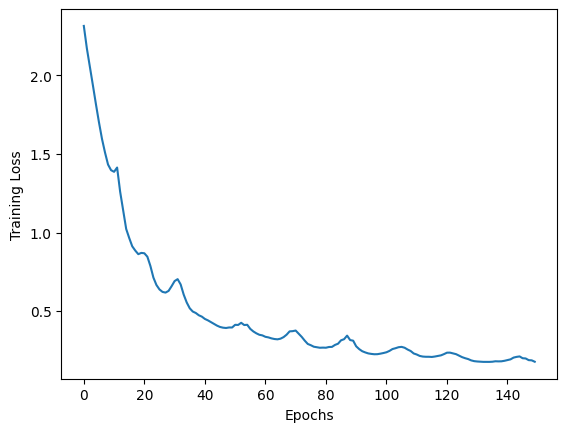

In [376]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

### Evaluation on test data [5 pts]

Now we will be evaluating the accuracy we get from the trained model. We feed training data and test data to the forward model along with the trained parameters. 

Note that, we need to convert the (probability) output of the forward pass into labels before evaluating accuracy. We can assign label based on the maximum probability. 

We assign estimated labels $$\hat{y}_i = \arg \max_c  \mathbf{p}_c $$ for every probility vector. 

In [377]:
# TODO
Y2_train, _ = forward(train_x, params)
Y2_train = Y2_train.T
Y2_train = np.argmax(Y2_train, axis=1)

print("Training accuracy:", (Y2_train == train_y).sum() / len(Y2_train))

Y2_test, _ = forward(test_x, params)
Y2_test = Y2_test.T
Y2_test = np.argmax(Y2_test, axis=1)

print("Test accuracy:", (Y2_test == test_y).sum() / len(Y2_test))

Training accuracy: 0.9608
Test accuracy: 0.9245


### Visualize some of the correct/miscalassified images [optional]

Now we will look at some images from training and test sets that were misclassified. 

Training set. 
Pick example from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives

Test set. 
Pick examples from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives


Training set examples for true/false positive/negative
Correctly classified: 


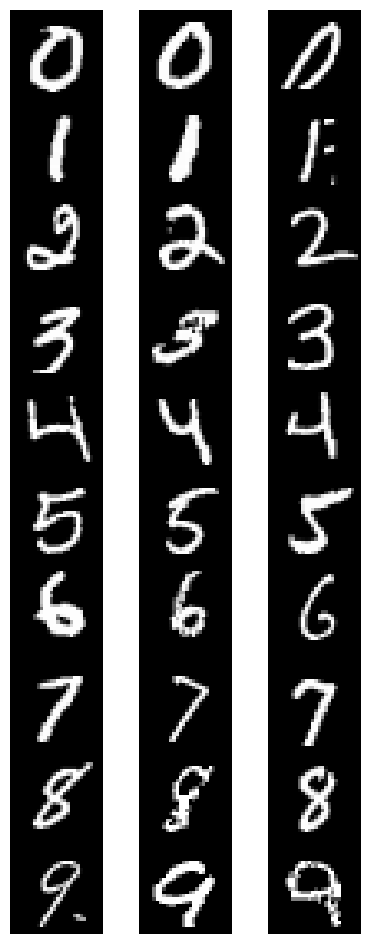

Incorrectly classified:


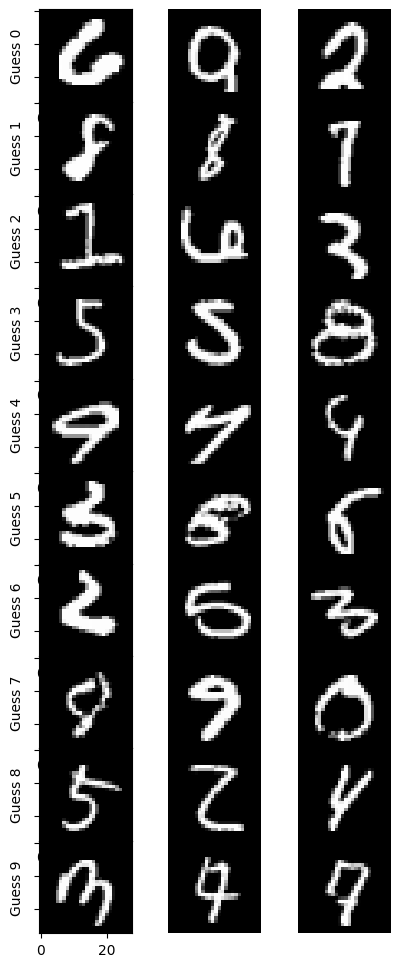

In [378]:
# TODO 
# Training set
print("Training set examples for true/false positive/negative")
Y_hat, caches = forward(train_x, params)
Y_hat = Y_hat.T
Y_hat = np.argmax(Y_hat, axis=1)

def shuffle_three(a, b, c):
    index = np.random.permutation(a.shape[0])
    return a[index], b[index], c[index]

Y_hat, tr_y, tr_x = shuffle_three(Y_hat, train_y, train_x.T)

# j images per plot
j = 3

print("Correctly classified: ")
# filter correct correct
correct_x = tr_x[tr_y == Y_hat]
correct_l = tr_y[tr_y == Y_hat]
uniques = np.unique(correct_l)

fig = plt.figure(figsize=(5, 12))
# iterate through uniques
for i in range(0, len(uniques)):
    # filter x's which match the class
    curr_x = correct_x[correct_l == uniques[i]]
    # iterate j times to display image
    for col in range(0, j):
        ax = fig.add_subplot(len(uniques), j, i*j + col + 1)
        img = plt.imshow(curr_x[col].reshape(28, 28))
        ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

print("Incorrectly classified:")
# filter correct correct
incorrect_x = tr_x[tr_y != Y_hat]
incorrect_l = Y_hat[tr_y != Y_hat]
uniques = np.unique(incorrect_l)

fig = plt.figure(figsize=(5, 12))
# iterate through uniques
for i in range(0, len(uniques)):
    # filter x's which match the class
    curr_x = incorrect_x[incorrect_l == uniques[i]]
    # iterate j times to display image
    for col in range(0, j):
        ax = fig.add_subplot(len(uniques), j, i*j + col + 1)
        img = plt.imshow(curr_x[col].reshape(28, 28))
        if col == 0:
            ax.set_ylabel(f"Guess {i}")
            ax.set_yticklabels([])
        else:
            ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Test set examples for true/false positive/negative
Correctly classified: 


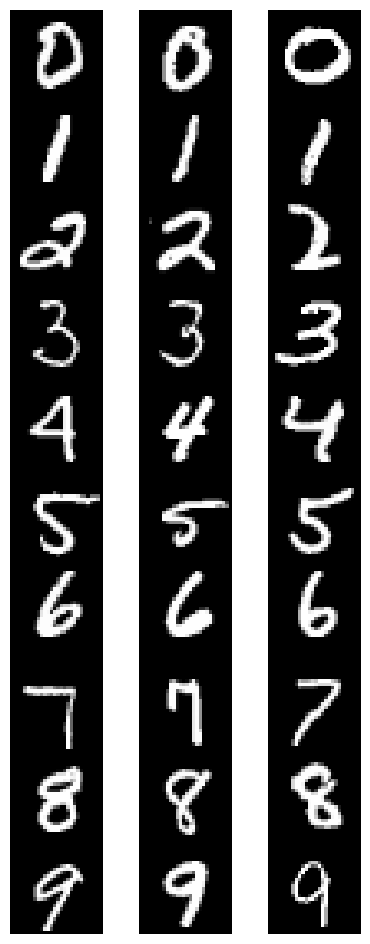

Incorrectly classified:


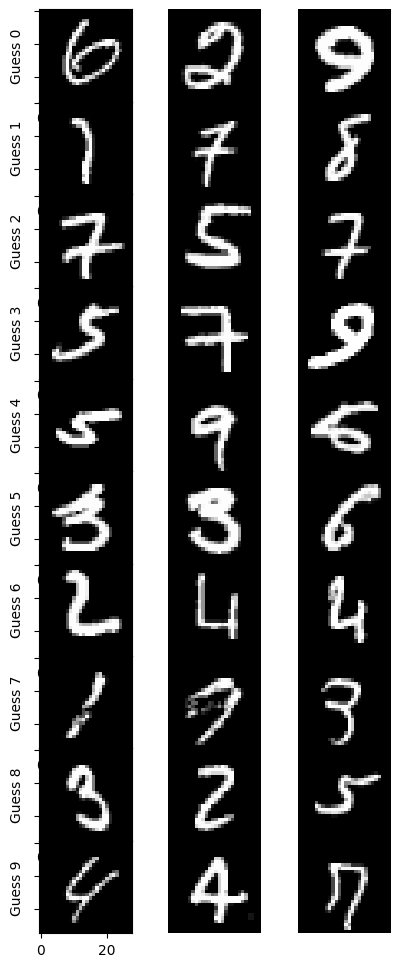

In [379]:
# TODO 
# test set
print("Test set examples for true/false positive/negative")
Y_hat, caches = forward(test_x, params)
Y_hat = Y_hat.T
Y_hat = np.argmax(Y_hat, axis=1)

def shuffle_three(a, b, c):
    index = np.random.permutation(a.shape[0])
    return a[index], b[index], c[index]

Y_hat, te_y, te_x = shuffle_three(Y_hat, test_y, test_x.T)

# j images per plot
j = 3

print("Correctly classified: ")
# filter correct correct
correct_x = te_x[te_y == Y_hat]
correct_l = te_y[te_y == Y_hat]
uniques = np.unique(correct_l)

fig = plt.figure(figsize=(5, 12))
# iterate through uniques
for i in range(0, len(uniques)):
    # filter x's which match the class
    curr_x = correct_x[correct_l == uniques[i]]
    # iterate j times to display image
    for col in range(0, j):
        ax = fig.add_subplot(len(uniques), j, i*j + col + 1)
        img = plt.imshow(curr_x[col].reshape(28, 28))
        ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

print("Incorrectly classified:")
# filter correct correct
incorrect_x = te_x[te_y != Y_hat]
incorrect_l = Y_hat[te_y != Y_hat]
uniques = np.unique(incorrect_l)

fig = plt.figure(figsize=(5, 12))
# iterate through uniques
for i in range(0, len(uniques)):
    # filter x's which match the class
    curr_x = incorrect_x[incorrect_l == uniques[i]]
    # iterate j times to display image
    for col in range(0, j):
        ax = fig.add_subplot(len(uniques), j, i*j + col + 1)
        img = plt.imshow(curr_x[col].reshape(28, 28))
        if col == 0:
            ax.set_ylabel(f"Guess {i}")
            ax.set_yticklabels([])
        else:
            ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Note about implementation

This is a note on two problems I have seen in the past and how they can be easily fixed. 

1. Summation along different axes ? 

2. Summation of gradients over samples ? 




**1. Summation to create probability vectors in the Softmax function**

Suppose X is a d x N array, in our case, it is 784 x 10000. 

`Z2 = W2 Y1 + b2  will be 10 x 10000 array `



`softmax(Z2)` will be a `10 x 10000` array in which we want to apply a softmax function on every column of `Z2` by first computing exponential and then normalizing the column to sum to 1, which is needed for it to be a probability vector. 




We can do that as 
```
probs = np.exp(Z2) 

# now you want to sum up each column and divide the column by the sum so that each column is a valid probability vector

probs /= np.sum(probs,axis=0,keepdims=True) # this makes sum of each column to 1
```

The **WRONG** thing to do is
```
probs /= np.sum(probs) 
# This is WRONG. np.sum() computes sum of the entire array. 
```



**2. Computing gradient for the entire loss function**

(this involves summation of N rank-one matrices in our notation.)




Suppose you have computed delta1, delta2 properly




Let's assume you computed
```
# delta2 is a 10 x 10000 array
# Y1 is a 256 x 10000 array
# N is 10000
# grad_W2 should be a 10 x 256 array
```



We can expand the formula for the gradient of the overall loss. 

$$\nabla_{W^{(2)}} Loss = \frac{1}{N}\sum_i \nabla_{W^{(2)}} Loss_i, $$ 

where 

$$\nabla_{W^{(2)}} Loss_i = \delta^{(2)} y^{(1)T} $$

is the gradient of the loss for $i$th training sample, where $\delta^{(2)}$ is a column of length 10 and $y^{(1)T}$ is a row of length 256, corresponding to $i$th training sample. Matrix product of column and row gives a a rank-1 matrix of size 10 x 256. 




To compute the gradient of loss over all the training samples, we need to average the rank-1 matrices for all N training samples.


We can write the code for that as 

```
# Sum gradient of loss for each sample
for i in range(N):
	grad_W2 += (1/N)*delta2[:,i,None].dot(Y1[:,i,None].T)

# OR we can compute grad_W2 without for loop as 
grad_W2 = 1/N*np.dot(delta2,Y1.T)
```

To see why this is true, you can convince yourself that matrix product of an `M x N` matrix with an `N x K` matrix can be written as a summation of N `M x K` rank-one matricess. 




Suppose 

$A = [\mathbf{a}_1 ~ \cdots ~ \mathbf{a}_N] \text{ and } B  = \begin{bmatrix} \mathbf{b}_1^T \\ \vdots \\ \mathbf{b}_N^T \end{bmatrix},$

where $\mathbf{a}_i, \mathbf{b}_i$ are columns of length $M, K$, respectively.  

 

We can write $AB$ as 




$$AB = \sum_{i = 1}^N \mathbf{a}_i \mathbf{b}_i^T.$$ 




 


---
## Submission instructions
1. Download this Colab to ipynb, and convert it to PDF. Follow similar steps as [here](https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab) but convert to PDF.
 - Download your .ipynb file. You can do it using only Google Colab. `File` -> `Download` -> `Download .ipynb`
 - Reupload it so Colab can see it. Click on the `Files` icon on the far left to expand the side bar. You can directly drag the downloaded .ipynb file to the area. Or click `Upload to session storage` icon and then select & upload your .ipynb file.
 - Conversion using %%shell. 
 ```
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!jupyter nbconvert --log-level CRITICAL --to pdf name_of_hw.ipynb
  ```
 - Your PDF file is ready. Click 3 dots and `Download`.


  

2. Upload the PDF to Gradescope, select the correct pdf pages for each question. **Important!**

3. Upload the ipynb file to Gradescope


Notice:
In case of errors in conversion, please check your LaTeX and debug. In Markdown, when you write in LaTeX math mode, do not leave any leading and trailing whitespaces inside the dollar signs ($). For example, write `(dollarSign)\mathbf(dollarSign)(dollarSign)` instead of `(dollarSign)(space)\mathbf{w}(dollarSign)`. Otherwise, nbconvert will throw an error and the generated pdf will be incomplete. [This is a bug of nbconvert.](https://tex.stackexchange.com/questions/367176/jupyter-notebook-latex-conversion-fails-escaped-and-other-symbols)


In [380]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [381]:
!jupyter nbconvert --log-level CRITICAL --to pdf fall2022_hw3.ipynb # make sure the ipynb name is correct

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbconvert` not found.
